# 基于卷积神经网络实现猫狗识别

下载数据集到本地，[链接](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data),下载方法可见 README.md

### 数据导入与预处理

In [1]:
import cv2 
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
import shutil
from IPython.display import display
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 定义调用模块

### 制作软连接模块

In [2]:
TRAIN_DATA_DIR = '/home/ubuntu/capstone/train'
TEST_DATA_DIR = '/home/ubuntu/capstone/test'

def make_symlink():

    image_dogs = []
    image_cats = []
    label_dogs = []
    label_cats = []
    test_images = []
    
    if not os.path.exists('newTrain'):
        os.mkdir('newTrain')
        os.mkdir('newTrain/cats')
        os.mkdir('newTrain/dogs')  
    else:
        shutil.rmtree('newTrain')
        os.mkdir('newTrain')
        os.mkdir('newTrain/cats')
        os.mkdir('newTrain/dogs')  
#         for filename in os.listdir('newTrain/cats'):
#             os.remove('newTrain/cats/'+ filename)
#         for filename in os.listdir('newTrain/dogs'):
#             os.remove('newTrain/dogs/'+ filename)
        
    if not os.path.exists('newTest'):
        os.mkdir('newTest')
    else:
        shutil.rmtree('newTest')
        os.mkdir('newTest')
#         if os.path.exists('newTest/test'):
#             for filename in os.listdir('newTest/test'):
#                 os.remove('newTest/test/'+ filename)
#             os.rmdir('newTest/test/')
    
    
    for img in tqdm(os.listdir(TRAIN_DATA_DIR)):
        images = os.path.join(img)
#         display(Image.open(TRAIN_DATA_DIR+'/'+img))
        
        labels = img.split('.')[0]
        if labels == 'cat':
            image_cats.append(images)
            label_cats.append(0)
        else:
            image_dogs.append(images)
            label_dogs.append(1)
    
#     print("images:", image_dogs)
    for img in tqdm(os.listdir(TEST_DATA_DIR)):
        images = os.path.join(img)
        test_images.append(images)
            
    for filename in image_cats:
        os.symlink(TRAIN_DATA_DIR + '/'+filename, 'newTrain/cats/'+filename)
        
    for filename in image_dogs:
        os.symlink(TRAIN_DATA_DIR + '/'+filename, 'newTrain/dogs/'+filename)
    
    os.symlink(TEST_DATA_DIR, 'newTest/test')
    
    return None
    

In [16]:
# make_symlink()

### 生成器输出模块

In [3]:
def make_generator(image_size, shuff):

#     input_images = []
    
#     for i_img in i_images:
# #       images = cv2.imread(images, cv2.IMREAD_COLOR)
#         images = image.load_img(i_img, target_size=(1,image_size,image_size, 3))
#         images = image.img_to_array(images)
#         input_images.append(images)
#     input_images = np.array(input_images)
    
#     # one hot eencoding
#     input_labels = np_utils.to_categorical(i_labels)
    
    
    # 图像预处理
    datagen = image.ImageDataGenerator()
#         horizontal_flip=True,
#         vertical_flip=True)
    if shuff:
        train_batch = datagen.flow_from_directory('newTrain', target_size=(image_size,image_size),
                                 batch_size=16,shuffle=True,seed=10)
    else:
        train_batch = datagen.flow_from_directory('newTrain', target_size=(image_size,image_size),
                                 batch_size=16,shuffle=False,seed=10)
    
    test_batch = datagen.flow_from_directory('newTest', target_size=(image_size, image_size),
                                 batch_size=16, shuffle=False,class_mode=None, seed=10)
    
    return train_batch, test_batch



### 结果可视化模块

In [37]:
def show_history(t_history,train,valid):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[valid])
    plt.title('Xception Model '+ train +' History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train '+train, 'valid '+valid], loc='upper left')
    plt.show()
    

In [5]:
def plot_images_labels_prediction(images, labels,prediction, idx, num=2):
    fig = plt.gcf()
    fig.set_size_inches(299, 299)
    if num>5 : 
        num=5
    for i in range(0,num):
        ax = plt.subplot(1,5,1+i)
        ax.imshow(images[idx], cmap='binary')
        title = "label:" + str(labels[idx])
        if len(prediction) > 0:
            title += "prediction:" + str(prediction[idx])
                
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()

# 建立模型
使用预训练过的模型，使用迁移学习的思想进行模型的建立，并试图进行模型融合训练，使用到的模型有
- Inception v3
- InceptionResNetV2
- Xception

## Xception模型

In [88]:
from keras.applications.xception import Xception, preprocess_input as xception_process
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_v3_process
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inception_resnet2_process
from keras.models import Model
from keras.optimizers import SGD
from IPython.display import SVG
from keras.layers import *
import h5py as h5py

In [7]:
input_tensor = Input(shape=(299,299,3))
model_xception = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

# for layer in model_xception.layers:
#     layer.trainable = False
    
x = GlobalAveragePooling2D()(model_xception.output)

# model1 = Flatten(name='flatten')(x)
model1 = Dense(1024, activation='relu', name='fc1')(x)
# model1 = Dense(1024, activation='relu', name='fc2')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(2, activation='softmax', name='prediction')(model1)

model_xception_pred = Model(model_xception.input, model1, name='xception')


- 选择损失函数(loss)为：categorical_crossentropy  
- 选择优化器(optimizer)为：Nadam() 
- 选择评价函数为：accuracy

In [8]:
model_xception_pred.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

### 训练模型

In [9]:
epochs = 10
image_size = 299

make_symlink()
train_generator1, test_generator1 = make_generator(image_size, shuff=True)
train_generator, test_generator = make_generator(image_size, shuff=False)
# xception_history = model_xception_pred.fit_generator(train_generator, epochs=epochs, verbose=1)

100%|██████████| 12500/12500 [00:00<00:00, 547908.33it/s]


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
xception_history = model_xception_pred.fit_generator(train_generator1, epochs=epochs, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 2116s 1s/step - loss: 0.2192 - acc: 0.9119
Epoch 2/10
1563/1563 [==============================] - 2107s 1s/step - loss: 0.1170 - acc: 0.9537
Epoch 3/10
1563/1563 [==============================] - 2106s 1s/step - loss: 0.0968 - acc: 0.9636
Epoch 4/10
1563/1563 [==============================] - 2108s 1s/step - loss: 0.0863 - acc: 0.9677
Epoch 5/10
 496/1563 [========>.....................] - ETA: 23:58 - loss: 0.0750 - acc: 0.9686

### 模型可视化

In [ ]:
SVG(model_to_dot(model_xception_pred, show_shapes=True).create(prog="dot", format='svg'))

### 执行结果可视化

In [ ]:
# accuracy 可视化
show_history(xception_history, 'acc', 'val_acc')

In [ ]:
# loss 可视化
show_history(xception_history, 'loss', 'val_loss')

## 建立混合模型

### Xception 模型

In [89]:
from keras.applications import xception
tensor = Input(shape=(299,299,3))
x_tensor = Lambda(xception_process)(tensor)
model_xception = Xception(input_tensor=x_tensor, include_top=False, weights='imagenet') #input_shape=(299,299,3)
x = GlobalAveragePooling2D()(model_xception.output)
# xception_model = Dense(128, activation='relu')(x)
xception_model = Model(model_xception.input, x)

xception_train = xception_model.predict_generator(train_generator, verbose=1)
xception_test = xception_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_Xception.h5") as h:
    h.create_dataset("train", data=xception_train)
    h.create_dataset("test", data=xception_test)
    h.create_dataset("t_label", data=train_generator.classes)


782/782 [==============================] - 317s 405ms/step


### Inception v3 模型

In [58]:
from keras.applications import inception_v3
y_tensor = Lambda(inception_v3_process)(tensor)
model_inception_v3 = InceptionV3(input_tensor=y_tensor, include_top=False, weights='imagenet') # input_shape=(299,299,3)
y = GlobalAveragePooling2D()(model_inception_v3.output)
# inceptionV3_model = Dense(128, activation='relu')(y)
inceptionV3_model = Model(inputs=tensor, outputs=y)

inceptionV3_train = inceptionV3_model.predict_generator(train_generator, verbose=1)
inceptionV3_test = inceptionV3_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_InceptionV3.h5") as h:
    h.create_dataset("train", data=inceptionV3_train)
    h.create_dataset("test", data=inceptionV3_test)
    h.create_dataset("t_label", data=train_generator.classes)

782/782 [==============================] - 181s 232ms/step


### InceptionResNetV2 模型

In [59]:
from keras.applications import inception_resnet_v2
z_tensor = Lambda(inception_resnet2_process)(tensor)
model_inceptionresnetv2 = InceptionResNetV2(input_tensor=z_tensor, include_top=False, weights='imagenet') # input_shape=(299,299,3)
z = GlobalAveragePooling2D()(model_inceptionresnetv2.output)
# inceptionresnetv2_model = Dense(128, activation='relu')(z)
inceptionresnetv2_model = Model(model_inceptionresnetv2.input, z)

inceptionresnetv2_train = inceptionresnetv2_model.predict_generator(train_generator, verbose=1)
inceptionresnetv2_test = inceptionresnetv2_model.predict_generator(test_generator, verbose=1)

# 将特征向量写入数据文件
with h5py.File("gap_InceptionResNetV2.h5") as h:
    h.create_dataset("train", data=inceptionresnetv2_train)
    h.create_dataset("test", data=inceptionresnetv2_test)
    h.create_dataset("t_label", data=train_generator.classes)

782/782 [==============================] - 395s 506ms/step


### 从文件中读取特征向量

In [90]:
from sklearn.utils import shuffle
from keras.utils import to_categorical

train_images = []
train_labels = []
valid_images = []
valid_labels = []
test_data = []

h5File = ["gap_Xception.h5"] #, "gap_InceptionV3.h5", "gap_InceptionResNetV2.h5"
for filename in h5File:
    print(filename)
    with h5py.File(filename, 'r') as h:
        train_images.append(np.array(h['train']))
        train_labels = np.array(h['t_label'])
        test_data.append(np.array(h['test']))


# 将list竖直拼接
train_images = np.concatenate(train_images, axis=1)
# train_labels = to_categorical(train_labels)
print('train_labels1:',len(train_images[0]))

print('train_labels2:',train_labels[0:12000])
# train_labels = np.concatenate(train_labels, axis=1)
test_data = np.concatenate(test_data, axis=1)

train_images, train_labels = shuffle(train_images, train_labels)
print("train_labels3:", train_labels.shape)

gap_Xception.h5
train_labels1: 2048
train_labels2: [0 0 0 ... 0 0 0]
train_labels3: (25000,)


In [61]:
# plot_images_labels_prediction(train_images[0:2], train_labels, [],0,2)

In [82]:
with h5py.File("gap_InceptionResNetV2.h5", 'r') as h:
    for k in list(h.keys())[::-1]:
        print(k, h[k].shape)

train (25000, 1536)
test (12500, 1536)
t_label (25000,)


In [91]:
train_input = Input(train_images.shape[1:])
print(train_images.shape[1:])
model = Dense(1024, activation='relu')(train_input)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

new_model = Model(train_input, model)

(2048,)


In [100]:
new_model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.002, momentum=0.9), metrics=['accuracy']) # SGD(lr=0.002, momentum=0.9)

In [101]:
new_model_history = new_model.fit(train_images, train_labels, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0427 - val_acc: 0.9952
Epoch 2/10
20000/20000 [==============================] - 5s 233us/step - loss: 0.0070 - acc: 0.9986 - val_loss: 0.0401 - val_acc: 0.9952
Epoch 3/10
20000/20000 [==============================] - 5s 230us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0380 - val_acc: 0.9954
Epoch 4/10
20000/20000 [==============================] - 5s 232us/step - loss: 0.0049 - acc: 0.9987 - val_loss: 0.0388 - val_acc: 0.9944
Epoch 5/10
20000/20000 [==============================] - 5s 226us/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.0355 - val_acc: 0.9956
Epoch 6/10
20000/20000 [==============================] - 5s 227us/step - loss: 0.0044 - acc: 0.9988 - val_loss: 0.0366 - val_acc: 0.9948
Epoch 7/10
20000/20000 [==============================] - 4s 219us/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.0343 - va

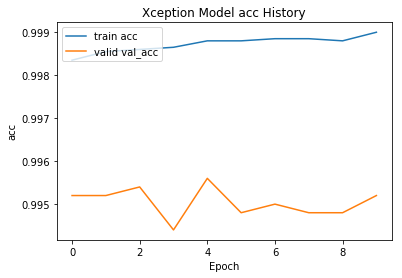

In [102]:
# accuracy 可视化
show_history(new_model_history, 'acc', 'val_acc')

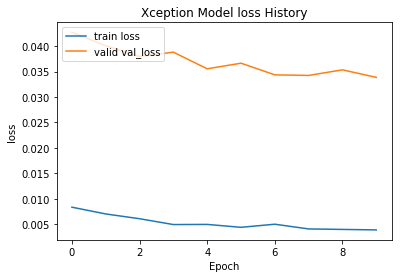

In [103]:
# loss 可视化
show_history(new_model_history, 'loss', 'val_loss')

## 测试

In [104]:
test_pred = new_model.predict(test_data, verbose=1)

12500/12500 [==============================] - 9s 708us/step


In [107]:
import pandas as pd
test_pred = test_pred.clip(min=0.005, max=0.995)

file = pd.read_csv("sample_submission.csv")

# gen = ImageDataGenerator()
# test_generator = gen.flow_from_directory(TEST_DATA_DIR, (299, 299),
#                                         shuffle=False, batch_size=16, class_mode=None)

for i, filename in enumerate(os.listdir('newTest/test')):
    index = int(filename.split('.')[0])
    file.set_value(index-1, 'label', test_pred[i])
    
file.to_csv('pred.csv', index=None)
file.head(10)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


,id,label
0,1,0.005
1,2,0.005
2,3,0.005
3,4,0.005
4,5,0.995
5,6,0.995
6,7,0.995
7,8,0.005
8,9,0.005
9,10,0.005
